In [1]:
import torch.nn as nn
import torch
import rawpy
import numpy as np
from torch.utils.data import DataLoader
from utils.datasets import LabeledDataset

import torchvision.transforms as transforms

import ignite.distributed as idist
from ignite.engine import Engine, Events
from ignite.contrib.handlers import ProgressBar
from ignite.metrics import FID, InceptionScore, RunningAverage

from torchinfo import summary

In [2]:
root_dir = "dataset"
sony_csv_files = ["dataset/Sony_train_list.txt"]
fuji_csv_files =  ["dataset/Fuji_train_list.txt"]

batch_size = 8
input_size = 512

pre_crop_transform = transforms.Compose([
    transforms.ToTensor()
])

sony_dataset = LabeledDataset(root_dir, *sony_csv_files, transform=pre_crop_transform)
sony_dataloader = DataLoader(sony_dataset, batch_size=batch_size, num_workers=8, shuffle=True)
print(sony_dataset[0][0].shape)
print(sony_dataset[0][1].shape)

torch.Size([1, 2848, 4256])
torch.Size([3, 2848, 4256])


In [3]:
from unet.unet_model import UNet
from torch import optim 
from ignite.handlers.param_scheduler import LRScheduler


net = nn.Sequential(
    UNet(4, 3*4)
)

model = idist.auto_model(net)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss = nn.MSELoss()
lr_scheduler = LRScheduler(optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.33))

2023-06-04 10:18:50,962 ignite.distributed.auto.auto_model INFO: Apply torch DataParallel on model


In [4]:
input_data = torch.randn(batch_size, 4, input_size, input_size)
summary(model, input_data = input_data)

Layer (type:depth-idx)                                  Output Shape              Param #
DataParallel                                            [8, 12, 512, 512]         --
├─Sequential: 1-1                                       [4, 12, 512, 512]         31,038,924
├─Sequential: 1-4                                       --                        (recursive)
│    └─UNet: 2-1                                        [4, 12, 512, 512]         31,038,924
│    └─UNet: 2-4                                        --                        (recursive)
│    │    └─DoubleConv: 3-1                             [4, 64, 512, 512]         39,424
│    │    └─DoubleConv: 3-23                            --                        (recursive)
├─Sequential: 1-3                                       [4, 12, 512, 512]         --
├─Sequential: 1-4                                       --                        (recursive)
│    └─UNet: 2-3                                        [4, 12, 512, 512]         --
│   

In [5]:
def random_crop(image_short, image_long, size):
    H = image_short.shape[2]
    W = image_short.shape[3]
    ps = size
    xx = np.random.randint(0, W - ps)
    yy = np.random.randint(0, H - ps)
    image_short = image_short[:,:,yy:yy + ps, xx:xx + ps]
    image_long = image_long[:,:,yy * 2:yy * 2 + ps * 2, xx * 2:xx * 2 + ps * 2]
    return image_short, image_long

def pack_sony_raw(batch):
    batch = torch.maximum(batch - 512, torch.Tensor([0]).to(device=idist.device())) / (16383 - 512)
    H = batch.shape[2]
    W = batch.shape[3]

    out = torch.cat((batch[:,:, 0:H:2, 0:W:2], 
                     batch[:,:, 0:H:2, 1:W:2],
                     batch[:,:, 1:H:2, 1:W:2],
                     batch[:,:, 1:H:2, 0:W:2]), dim=1)
    return out

In [6]:
def training_step(engine, batch):
    model.train()
    optimizer.zero_grad()
    short, long, ratio, cam_model, exposure_ratio, _, _ = batch

    short = short.to(idist.device())
    long = long.to(idist.device())

    short = pack_sony_raw(short)
    long = long / 65535.0
    short = short * exposure_ratio.float().to(idist.device()).view(-1, 1, 1, 1)
    short, long = random_crop(short, long, input_size)

    output = model(short)
    output = torch.nn.functional.pixel_shuffle(output, 2)
    g_loss = loss(output, long)
    g_loss.backward()
    optimizer.step()
    return {"Loss_G": g_loss.item()}

In [7]:
trainer = Engine(training_step)
trainer.add_event_handler(Events.ITERATION_STARTED, lr_scheduler)
RunningAverage(output_transform=lambda x: x["Loss_G"]).attach(trainer, 'Loss_G')
ProgressBar().attach(trainer, metric_names=['Loss_G'])

G_losses = []

@trainer.on(Events.ITERATION_COMPLETED)
def store_losses(engine):
    o = engine.state.output
    G_losses.append(o["Loss_G"])

/home/pikachu/.local/lib/python3.10/site-packages/ignite/contrib/handlers/tqdm_logger.py:127: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [8]:
def training(*args):
    trainer.run(sony_dataloader, max_epochs=10)

with idist.Parallel(backend='nccl') as parallel:
    parallel.run(training)

2023-06-04 10:18:55,511 ignite.distributed.launcher.Parallel INFO: Initialized processing group with backend: 'nccl'
2023-06-04 10:18:55,512 ignite.distributed.launcher.Parallel INFO: - Run '<function training at 0x7fc9dc8580d0>' in 1 processes
Epoch [5/10]: [46/234]  20%|█▉        , Loss_G=0.0121 [00:53<03:28] Engine run is terminating due to exception: 
2023-06-04 10:37:45,092 ignite.distributed.launcher.Parallel INFO: Finalized processing group with backend: 'nccl'


KeyboardInterrupt: 

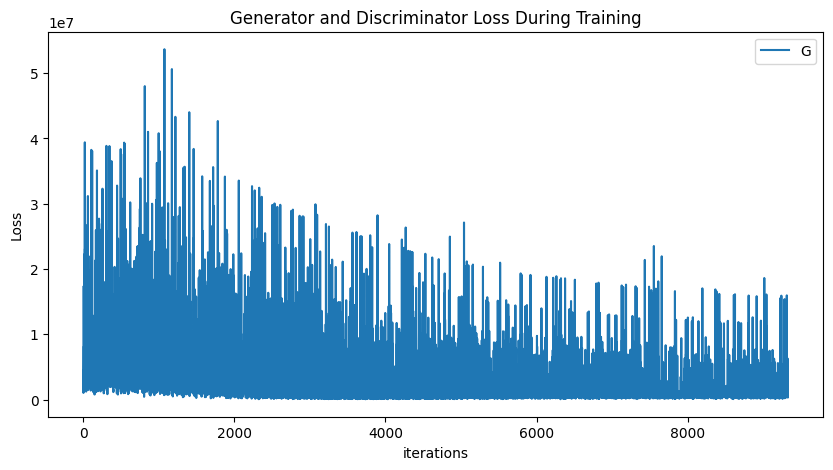

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()

In [ ]:
torch.save({
            'epoch': 10,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, 'model_seed_{}.pt'.format(torch.random.initial_seed()))

59246408.04508431
0 0


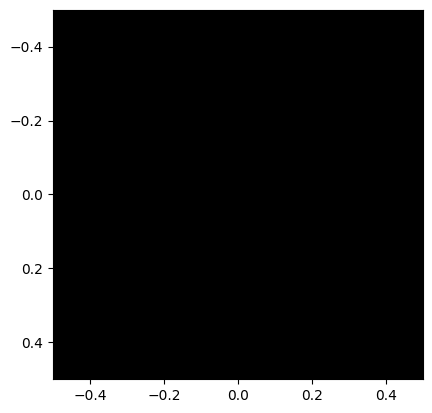

In [ ]:
import cv2
with torch.no_grad():
    model.eval()
    out = model(transforms.CenterCrop(input_size)(dataset[0][0].unsqueeze(0)).to(idist.device())).to('cpu').numpy()
    out = out.astype(np.uint16)
    gt = transforms.CenterCrop(input_size)(dataset[0][1]).numpy().astype(np.uint16)
    dist = np.linalg.norm(gt-out)
    print(dist)
    colour = cv2.cvtColor(out, cv2.COLOR_BAYER_BG2BGR)
    print(np.min(colour), np.max(colour))
    plt.imshow(colour)